In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.network.heterogeneous_network import HeterogeneousNetwork

from moge.visualization.plot_data import matrix_heatmap

#  Import network from file

In [1]:
import pickle

# READ
with open('moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/LMN_mirtarbase_starbase_lncbase_npinter_lncrna2target.train.pickle', 'rb') as file:
    network = pickle.load(file)
#     network.process_genes_info()

# READ Edgeslist
# network.import_edgelist_file(
#     file="moge/data/LMN_only_directed/lmn_l08_m08_l08__correlation_node_similarity.edgelist", 
#                              is_directed=True)

In [2]:
# READ edgelists
with open('moge/data/LMN_future_recall/TEST/Interactions_Affinity/LMN_mirtarbase_starbase_lncbase_npinter_lncrna2target.test.pickle', 'rb') as file:
    network_val = pickle.load(file)
#     network_val.process_genes_info()

# print("network_test", network_test.G.number_of_edges())
# print("network_val", network_val.G.number_of_edges())

In [4]:
import pickle
with open('moge/data/luad_data_multi_seq.pickle', 'rb') as file:
    luad_data = pickle.load(file)
    network.multi_omics_data = luad_data
    network.process_genes_info()

Genes info columns: ['Transcript sequence', 'Disease association', 'locus_type', 'GO Terms', 'Family']
Number of nodes without seq removed: -50
Total nodes (filtered): 32530


In [5]:
network.G.remove_edges_from([(u,v,d) for u,v,d in network.G.edges(data=True) if d["type"]=="u" or d["type"]=="u_n"])

# Data Visualization

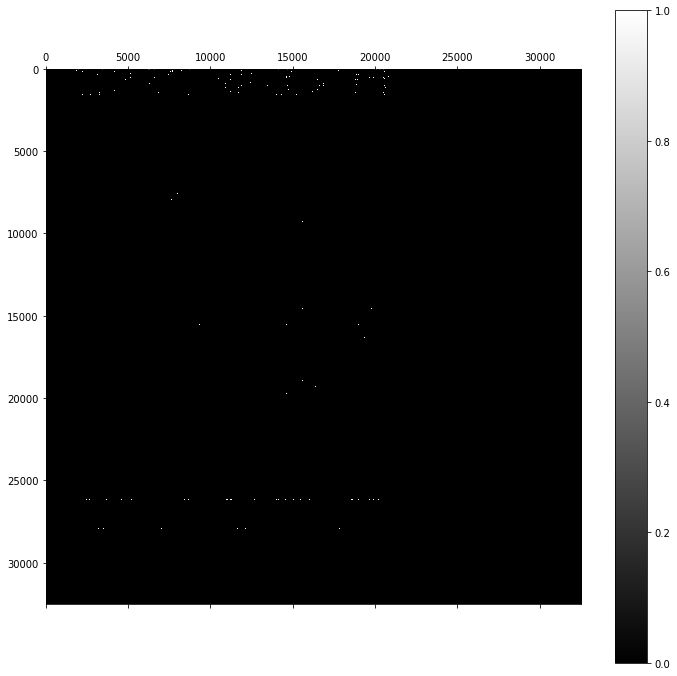

In [5]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list).todense())

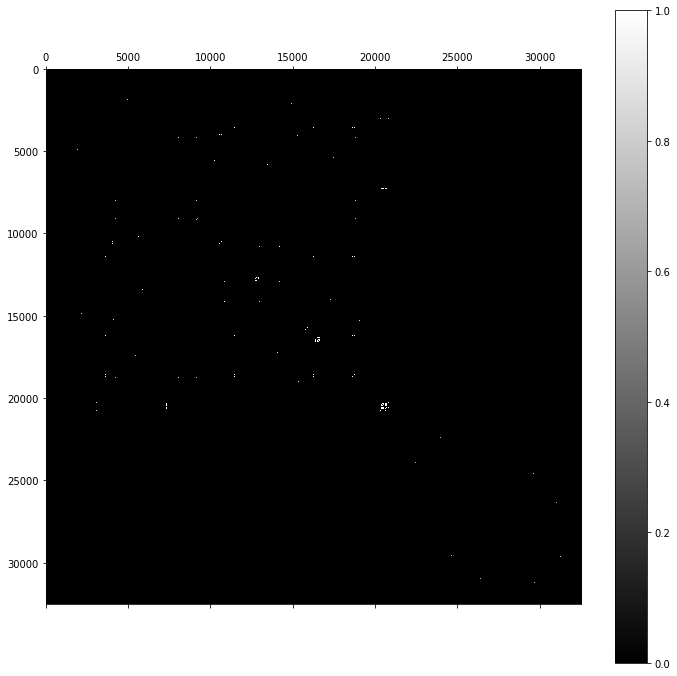

In [6]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list).todense())

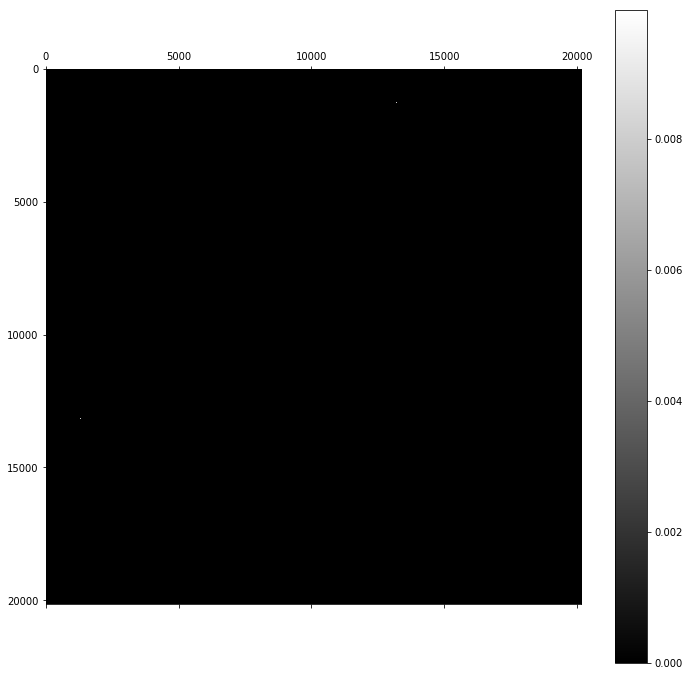

In [7]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.nodes["GE"]).todense())

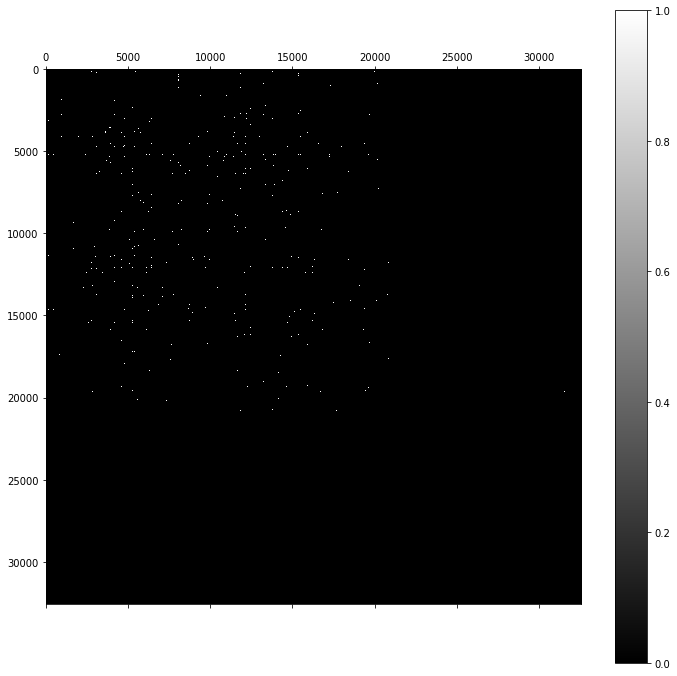

In [8]:
# The test data to recall
matrix_heatmap(network_val.get_adjacency_matrix(edge_types=["d"], node_list=network_val.node_list).todense())

# Train

In [5]:
from moge.embedding.siamese_graph_embedding import SiameseGraphEmbedding

siamese = SiameseGraphEmbedding(d=128, batch_size=2048, lr=0.01, epochs=20, negative_sampling_ratio=2.0,
                                 max_length=1400, truncating="random", verbose=True)

In [6]:
siamese.learn_embedding(network, network_val=network_val, multi_gpu=True, 
                        subsample=False, directed_proba=0.8, n_steps=2000, validation_steps=50, compression_func="log",
                        seed=2)

Ed_count: 376094 , Eu_count: 347505 , En_count: 1612996
Ens_count: 752188
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}
Ed_count: 1161527 , Eu_count: 0 , En_count: 0
Ens_count: 2323054
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}
Embedding Tensor("embedding_1/embedding_lookup/Identity:0", shape=(?, ?, 5), dtype=float32, device=/device:CPU:0)
conv2D Tensor("lambda_2/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:CPU:0)
max pooling_1 Tensor("max_pooling1d_1/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:CPU:0)
conv1d_2 Tensor("conv1d_1/Relu:0", shape=(?, ?, 320), dtype=float32, device=/device:CPU:0)
max pooling_2 Tensor("max_pooling1d_2/Squeeze:0", shape=(?, ?, 320), dtype=float32, device=/device:CPU:0)
brnn Tensor("bidirectional_1/concat_2:0", shape=(?, 640), dtype=float32, device=/device:CPU:0)
embedding Tensor("dense_3/BiasAdd:0", shape=(?, 128), dtype=float32, device=/device:CPU:0)
Network total weights: 3557179
Epoch 1/20
1508/1508 

In [46]:
siamese.build_keras_model(multi_gpu=True)

Embedding Tensor("embedding_1/embedding_lookup/Identity:0", shape=(?, ?, 5), dtype=float32, device=/device:CPU:0)
conv2D Tensor("lambda_2/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:CPU:0)
max pooling_1 Tensor("max_pooling1d_1/Squeeze:0", shape=(?, ?, 192), dtype=float32, device=/device:CPU:0)
conv1d_2 Tensor("conv1d_1/Relu:0", shape=(?, ?, 320), dtype=float32, device=/device:CPU:0)
max pooling_2 Tensor("max_pooling1d_2/Squeeze:0", shape=(?, ?, 320), dtype=float32, device=/device:CPU:0)
brnn Tensor("bidirectional_1/concat_2:0", shape=(?, 640), dtype=float32, device=/device:CPU:0)
embedding Tensor("dense_3/BiasAdd:0", shape=(?, 128), dtype=float32, device=/device:CPU:0)
abs_diff_directed: Tensor("lambda_3/Abs:0", shape=(2048, 64), dtype=float32, device=/device:CPU:0)
alpha_directed: Tensor("alpha_directed/Sigmoid:0", shape=(2048, 1), dtype=float32, device=/device:CPU:0)
abs_diff_undirected: Tensor("lambda_4/Abs:0", shape=(2048, 128), dtype=float32, device=/device:CPU:0)

ValueError: Output tensors to a Model must be the output of a Keras `Layer` (thus holding past layer metadata). Found: Tensor("Select_1:0", shape=(2048, 1), dtype=float32, device=/device:CPU:0)

# Visualize Embeddings

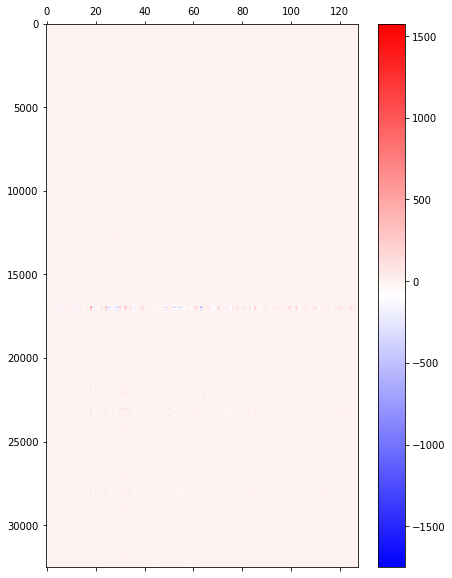

In [6]:
matrix_heatmap(siamese.get_embedding(), cmap="bwr", aspect='auto', figsize=(7,10))

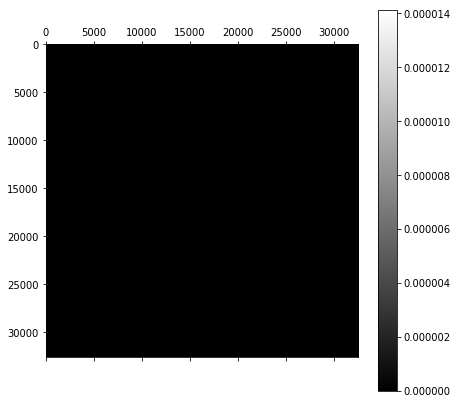

In [7]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="d", from_dist=False, node_l=network.node_list),figsize=(7,7))

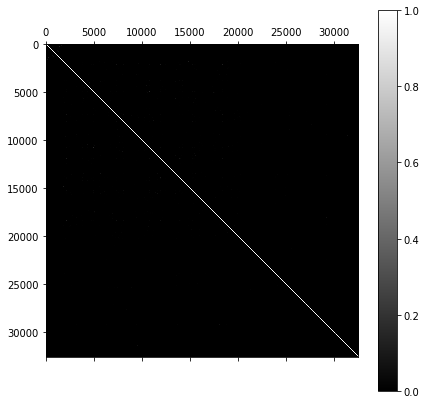

In [8]:
matrix_heatmap(siamese.get_reconstructed_adj(edge_type="u", from_dist=False, node_l=network_val.node_list), figsize=(7,7))

# Plot measures on training and testing

dict_keys(['val_loss', 'val_acc', 'val_precision', 'val_recall', 'loss', 'acc', 'precision', 'recall'])


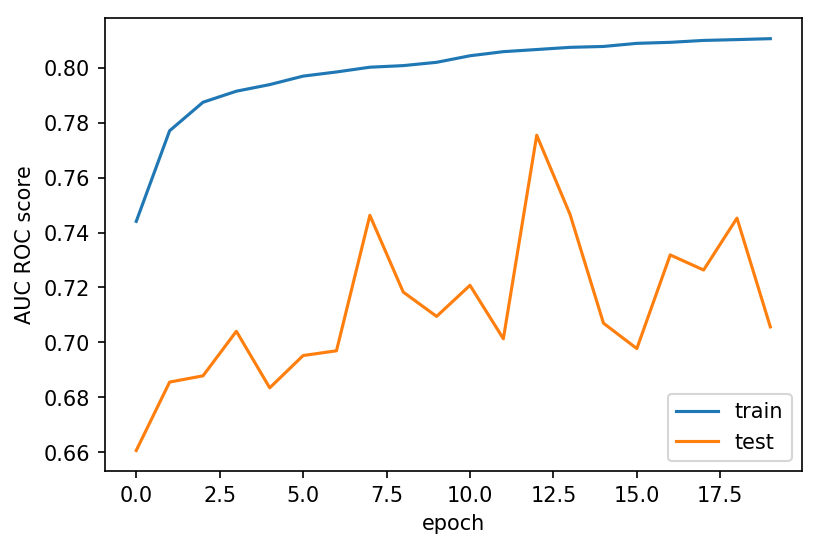

In [9]:
import matplotlib.pyplot as plt
history = siamese.history
print(history.history.keys())
plt.figure(dpi=150)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
# plt.title('Link prediction performance')
plt.ylabel('AUC ROC score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [10]:
with siamese.sess.as_default():
    siamese.alpha_directed.eval()

AttributeError: 'SiameseGraphEmbedding' object has no attribute 'alpha_directed'

# Save Model & Embedding

In [7]:
siamese.lstm_network.save("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lstm_128.randtrunc.multi.edge20.full.l1_bce.e20.h5")

In [9]:
siamese.truncating = "post"
siamese.save_embeddings("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_edges20_train.siamese.multi_seq.full.l1_bce.varlen.emb", 
                        variable_length=True, recompute=True, minlen=100)

In [ ]:
lstm_network.summary()

# Import different models

In [3]:
from moge.embedding.static_graph_embedding import ImportedGraphEmbedding

node2vec_emb = ImportedGraphEmbedding(d=128, method_name="node2vec")
node2vec_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.node2vec.emb", 
                          node_list=network.node_list)

line_emb = ImportedGraphEmbedding(d=128, method_name="LINE")
line_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.line.emb", 
                          node_list=network.node_list)

hope_emb = ImportedGraphEmbedding(d=128, method_name="HOPE")
hope_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.hope.emb", 
                          node_list=network.node_list)

sdne_emb = ImportedGraphEmbedding(d=128, method_name="SDNE")
sdne_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Only/lmn_train.all.sdne.emb", 
                          node_list=network.node_list)


rna2rna_emb = ImportedGraphEmbedding(d=128, method_name="rna2rna")
rna2rna_emb.import_embedding("moge/data/LMN_future_recall/TRAIN/Interactions_Affinity/lmn_edges20_train.siamese.multi_seq.full.l1_bce.varlen.emb", 
                         node_list=network.node_list)
print()

Using TensorFlow backend.


node2vec imported (20507, 128)
LINE imported (20507, 128)
HOPE imported (20507, 128)
SDNE imported (20507, 128)
rna2rna imported (32533, 128)



# Prepare True label

In [5]:
from moge.network.data_generator import DataGenerator

negative_sampling_ratio = 2.0
generator_Ed = DataGenerator(network=network_val, 
                             negative_sampling_ratio=negative_sampling_ratio,
#                              batch_size=siamese.batch_size,
                             maxlen=1400,
                             truncating="post",
                             shuffle=True, seed=0)
generator_Ed.on_epoch_end()


Ed_count: 1161527 , Eu_count: 0 , En_count: 0
Ens_count: 2323054
num_words: None {'A': 1, 'T': 2, 'G': 3, 'C': 4, 'U': 5}


In [ ]:
X, y_true = generator_Ed.make_dataset()
y_true.shape
# y_true = y_true.astype(int)
# y_true = (y_true > 0).astype(int)

(3484581, 1)

In [ ]:
y_pred_dict = {}
y_pred_dict["LINE"] = line_emb.predict(X)
y_pred_dict["HOPE"] = hope_emb.predict(X)
y_pred_dict["SDNE"] = sdne_emb.predict(X)
y_pred_dict["node2vec"] = node2vec_emb.predict(X)
y_pred_dict["rna2rna"] = rna2rna_emb.predict(X)
# y_pred_dict["siamese"] = siamese.predict_generator(generator_Ed)

In [ ]:
color_dict = {}
color_dict["LINE"] = "b"
color_dict["HOPE"] = "b"
color_dict["SDNE"] = "y"
color_dict["node2vec"] = "g"
color_dict["rna2rna"] = "r"
color_dict["siamese"] = "r"

ls_dict = {}
ls_dict["LINE"] = ":"
ls_dict["HOPE"] = "-"
ls_dict["SDNE"] = "--"
ls_dict["node2vec"] = "--"
ls_dict["rna2rna"] = "-"
ls_dict["siamese"] = ":"

# Plot Precision-Recall Curve

In [ ]:
import matplotlib.pyplot as plt
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score ,precision_recall_curve

fig = plt.figure(figsize=(4, 4), dpi=300)
ax = fig.add_subplot(111)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

for method in y_pred_dict.keys():
    y_prob_pred = y_pred_dict[method]
    average_precision = average_precision_score(y_true=y_true, y_score=y_prob_pred)
    precision, recall, _ = precision_recall_curve(y_true=y_true, probas_pred=y_prob_pred, pos_label=1)

    ax.plot(recall, precision, color=color_dict[method], ls=ls_dict[method],
             label=method+'. AUPR={0:0.2f}'.format(average_precision))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.00])
plt.xlim([0.0, 1.0])
plt.legend(loc="lower right")
plt.title('starBase mRNA-RNA 50%-test PR curve')
plt.show()

In [17]:
# fig.savefig("moge/data/LMN_only_directed/results/starBase_mRNA-RNA_50_pr.pdf", bbox_inches='tight')

# Top-K Link Prediction

In [ ]:
from moge.evaluation.link_prediction import evaluate_top_k_link_pred

methods = {}
methods["node2vec"] = node2vec_emb
methods["LINE"] = line_emb
methods["HOPE"] = hope_emb
methods["SDNE"] = sdne_emb
methods["rna2rna"] = rna2rna_emb
# methods["siamese"] = siamese

for method in methods.keys():
    print(method)
    print(evaluate_top_k_link_pred(methods[method], network_train=network, network_test=network_val, 
                         node_list=methods[method].node_list, edge_type="d", top_k=10000))

In [ ]:
from moge.evaluation.node_clustering import evaluate_clustering

for method in methods.keys():
    print(method)
    print(evaluate_clustering(methods[method], network=network, node_label="Family", 
                              max_clusters=500, n_clusters=None))

In [ ]:
from moge.visualization.visualize_embedding import visualize_embedding
visualize_embedding(rna2rna_emb, network=network, node_label="locus_type", 
                    edgelist=network_val.get_edgelist(node_list=network_val.nodes, edge_types=["d"]),
#                     test_nodes=node_list,
                    cmap="gist_ncar",)

# AUC Rate

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>